
## #1 
Consider the following finite horizon consumption-savings problem with indivisible labor supply. A household lives from ages $t = 1$ to $t = T$ and then dies. In every period t, a household chooses consumption $c_t$ and whether or not to work. We denote $h_t = 1$ if the household works in period t and $h_t = 0$ if not. The household receives a wage $w_t$ if working and an unemploymen benefit $b$ if not working. The household’s Bellman equation is

$$ V_t(a) = \max_{{c,h}} u(c) - \psi h + \beta V_{t+1}(a') $$

subject to

$$ c + a' = (1+r) a + w_t h + b (1 - h)$$
$$ a' \ge 0$$

Assume the following functional forms and parameter values

$$ u(c) = \frac{c^{1-\gamma} -1}{1-\gamma} $$
$$ \gamma = 2 $$
$$ \beta = 0.97 $$
$$ r = 0.03 $$
$$ \psi = 0.1 $$
$$ T = 50 $$
$$ w_t = \begin{cases} \frac{t}{10} & \text{ if t} \le \frac{T}{2}\\
\frac{T + 1 - t}{10} & \text{ if t} > \frac{T}{2}
\end{cases}$$
$$ b = 0.5 $$

# (a) Write some computer code that uses value function iteration to solve for the households optimal decisions and policy rules and produce a plot of the optimal paths of consumption (c), work (h) and wealth (a) as a function of the household’s age.

In [25]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

Since this is a finite horizon problem, time t is a state. We need to solve by backward induction, and know that $V_{T+k}(x) = 0 \quad \forall x \quad \forall k>0$. 

In [26]:
gamma = 2
beta = 0.97
r = 0.03
psi = 0.1
T = 50
b = 0.5
R = 1 + r
tau = 0

In [27]:
amin = 0
amax = 20
na = 11
nh = 2
a_grid = np.linspace(amin,amax,na)
print(a_grid)
h_grid = np.linspace(0,1,nh)
c_grid = np.linspace(0,20,201)

# tau here is the tax from (c)iii
def w(t,tau=0):
    if t > T/2:
        return (1-tau)*(T + 1 - t)/10
    else: 
        return (1-tau)*t/10
    
def u(c,h):
    return (c**(1-gamma)-1)/(1-gamma) - psi*h
h_grid

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]


array([ 0.,  1.])

In the final period, the agent should consume all that's available to him. In particular, $a_T' = 0$
Hence the problem simplifies to 
$$ V_T(a) = \max_{{c,h}} u(c) - \psi h $$
subject to
$$ c = (1+r) a + w_T h + b (1 - h)$$
The Lagrangian:
$$\mathscr{L} = u(c) - \psi h + \lambda ((1+r) a + w_T h + b (1 - h) - c)$$
First order conditions are:
$$ c^{-\gamma} = \lambda$$
$$ - \psi = \lambda ( w_T - b )$$

For each a, we loop over all possible values of h and c, and pick the combination that maximizes the objective function.

### I have a modularized version of the code in the other folder.

In [56]:
# Initialize
T = 50
na = 801
amax = 7
nh = 2

V = np.zeros((na,T))
sav = np.zeros((na,T))
savind = np.zeros((na,T))
con = np.zeros((na,T))
h = np.zeros((na,T))

a_grid = np.linspace(amin,amax,na)
#print(agrid)
h_grid = np.linspace(0,1,nh)


hvals = np.linspace(0,1,nh)
## Decisions at t=T
#savind[:,T-1] = [i for i in range(0,len(agrid)) if agrid[i]==0]
sav[:,T-1] =0
hind = np.zeros((na,T))
conh = np.zeros((na,nh))
Vh = np.zeros((na,nh))
#print(conh.shape)
#psi = -0.5
for i in range(nh):
    #hind[:,T-1] = np.zeros((na,1))
    #print(a_grid.shape)
    conh[:,i] = R*a_grid + w(T)*hvals[i] + (1-hvals[i])*b - sav[:,T-1]
    Vh[:,i] = u(conh[:,i],hvals[i])

Vh
#print(conh)
#print(Vh)
V[:,T-1] = np.amax(Vh,1)
#print(V)
hind = np.argmax(Vh,1)
#print(hind)
con[:,T-1] = np.choose(hind, conh.T)
#print(con)
h[:,T-1] = np.choose(hind, h_grid.T)
#print(h)



In [57]:
cash = np.zeros(conh.shape)
#print(cash)
# Solving backward
for it in np.arange(T-2,-1,-1):
    print("Solving at age ", (it+1))
    for ia in range(0,na):
        for i in range(nh):
            #hind[:,T-1] = np.zeros((na,1))
            #print(a_grid.shape)
            #conh[:,i] 
            #print(cash[:])
            cash[:,i] = R*a_grid[ia] + w(it+1,tau)*hvals[i] + (1-hvals[i])*b
            #print(cash[:,i])
            conh[:,i] = np.maximum((cash[:,i] - a_grid), 1 * 10 ** -10)
            #print(c)
            Vh[:,i] = u(conh[:,i],hvals[i]) + beta * V[:,it+1] 
        #print(Vh)
        hind = np.argmax(Vh,1)
        #print(hind)
        cashchoice = np.choose(hind, cash.T)
        conchoice = np.choose(hind, conh.T)
        hchoice = np.choose(hind, h_grid.T)
        #print("dw",hchoice[4])
        #print("hchoice",hchoice)
        Vchoice = np.amax(Vh,1)
        #print("Vchoice",Vchoice)
        Vind = np.argmax(Vchoice)
        #print(Vind)
        V[ia,it] = np.max(Vchoice)
        #print("h",h)
        h[ia,it] = hchoice[Vind]
        #print(h)
        sav[ia,it]= a_grid[Vind]
        savind[ia,it] = Vind
        con[ia,it] = cashchoice[Vind] -sav[ia,it]
        
        
        

        
#print(savind)
#print(h)
#h[np.int_(aindsim[it]),it]

Solving at age  49
Solving at age  48
Solving at age  47
Solving at age  46
Solving at age  45
Solving at age  44
Solving at age  43
Solving at age  42
Solving at age  41
Solving at age  40
Solving at age  39
Solving at age  38
Solving at age  37
Solving at age  36
Solving at age  35
Solving at age  34
Solving at age  33
Solving at age  32
Solving at age  31
Solving at age  30
Solving at age  29
Solving at age  28
Solving at age  27
Solving at age  26
Solving at age  25
Solving at age  24
Solving at age  23
Solving at age  22
Solving at age  21
Solving at age  20
Solving at age  19
Solving at age  18
Solving at age  17
Solving at age  16
Solving at age  15
Solving at age  14
Solving at age  13
Solving at age  12
Solving at age  11
Solving at age  10
Solving at age  9
Solving at age  8
Solving at age  7
Solving at age  6
Solving at age  5
Solving at age  4
Solving at age  3
Solving at age  2
Solving at age  1


In [58]:
aindsim = np.zeros(T+1)
hsim = np.zeros(T+1)
csim = np.zeros(T+1)
asim = np.zeros(T+1)

# initial assets
ainitial = 1.8

# allocate to nearest point on agrid
inter = interpolate.interp1d(a_grid,range(0,na),'nearest')
#print(inter)
aindsim[0] = inter(ainitial) #a_grid[np.int(inter(ainitial))]   
asim[0] = a_grid[np.int(aindsim[0])]

asim
for it in range(0,T):
    print('Simulating, time period', (it+1))
    #asset choice
    aindsim[it+1] = savind[np.int_(aindsim[it]),it]
    asim[it+1] = a_grid[np.int(aindsim[it+1])]
    hsim[it] = h[np.int(aindsim[it]),it]
    csim[it] = R*asim[it] + w(it,tau)*hsim[it] + (1 - hsim[it])*b - asim[it+1]
print(hsim)
asim
csim


Simulating, time period 1
Simulating, time period 2
Simulating, time period 3
Simulating, time period 4
Simulating, time period 5
Simulating, time period 6
Simulating, time period 7
Simulating, time period 8
Simulating, time period 9
Simulating, time period 10
Simulating, time period 11
Simulating, time period 12
Simulating, time period 13
Simulating, time period 14
Simulating, time period 15
Simulating, time period 16
Simulating, time period 17
Simulating, time period 18
Simulating, time period 19
Simulating, time period 20
Simulating, time period 21
Simulating, time period 22
Simulating, time period 23
Simulating, time period 24
Simulating, time period 25
Simulating, time period 26
Simulating, time period 27
Simulating, time period 28
Simulating, time period 29
Simulating, time period 30
Simulating, time period 31
Simulating, time period 32
Simulating, time period 33
Simulating, time period 34
Simulating, time period 35
Simulating, time period 36
Simulating, time period 37
Simulating

array([ 0.825325 ,  0.8259375,  0.8262875,  0.826375 ,  0.8262   ,
        0.7207625,  0.7269625,  0.7270375,  0.8      ,  0.9      ,
        1.       ,  1.1      ,  1.2      ,  1.3      ,  1.4      ,
        1.5      ,  1.6      ,  1.7      ,  1.7125   ,  1.710125 ,
        1.7109   ,  1.706075 ,  1.7134125,  1.7064   ,  1.7118125,
        1.8081375,  1.9015   ,  1.9015125,  1.9079125,  1.9029375,
        1.90435  ,  1.9031375,  1.8993   ,  1.9015875,  1.9009875,
        1.81     ,  1.71     ,  1.61     ,  1.53625  ,  1.5404625,
        1.541525 ,  1.5394375,  1.5342   ,  1.4358125,  1.439225 ,
        1.4331   ,  1.4352   ,  1.4365125,  1.4282875,  1.4282875,  0.       ])

/Users/Jan/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


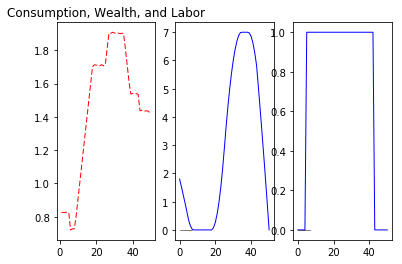

In [59]:
fig_1 = plt.figure(1)
plt.title('Consumption, Wealth, and Labor')
#fig_1.figsize((10,10))
#consumption and income path
plt.subplot(1,3,1)
#plt.plot(range(1,51),y, 'k-', lw=1)
plt.plot(range(1,T+1),csim[0:T],'r--', lw=1)
plt.grid
plt.title('Consumption, Wealth, and Labor')
plt.legend(label = ('Income','Consumption'))
#plt.show()

plt.subplot(1,3,2)
plt.plot(range(0,T+1),asim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)


plt.subplot(1,3,3)
plt.plot(range(0,T+1),hsim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)
plt.show()

# (b) Give the economic intuition for why the paths of consumption, work and wealth look the way that they do.

- Consumption, wealth and labor paths:
At the beginning of her life, the agent earns a very low wage, and can thus only consume very little. In anticipation of her future earnings, she consumes her initial wealth and in earlier periods, and then saves up again once she earns a lot. She only works when the wage she receives is both higher than unemployment benefits, and the additional consumption opportunities outweigh the disutility of working. Thus, she only works in the middle of her life. 
Towards the end of her life, she consumes the wealth she had accumulated while she worked.

# (c) Show how the optimal paths change in each of the following circumstances. In each case, provide the economic intuition behind your result:

## i. The interest rate falls to r = 0.01.

In [62]:
r = 0.01
R = 1 + r

Solving at age  49
Solving at age  48
Solving at age  47
Solving at age  46
Solving at age  45
Solving at age  44
Solving at age  43
Solving at age  42
Solving at age  41
Solving at age  40
Solving at age  39
Solving at age  38
Solving at age  37
Solving at age  36
Solving at age  35
Solving at age  34
Solving at age  33
Solving at age  32
Solving at age  31
Solving at age  30
Solving at age  29
Solving at age  28
Solving at age  27
Solving at age  26
Solving at age  25
Solving at age  24
Solving at age  23
Solving at age  22
Solving at age  21
Solving at age  20
Solving at age  19
Solving at age  18
Solving at age  17
Solving at age  16
Solving at age  15
Solving at age  14
Solving at age  13
Solving at age  12
Solving at age  11
Solving at age  10
Solving at age  9
Solving at age  8
Solving at age  7
Solving at age  6
Solving at age  5
Solving at age  4
Solving at age  3
Solving at age  2
Solving at age  1
Simulating, time period 1
Simulating, time period 2
Simulating, time period 3


/Users/Jan/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


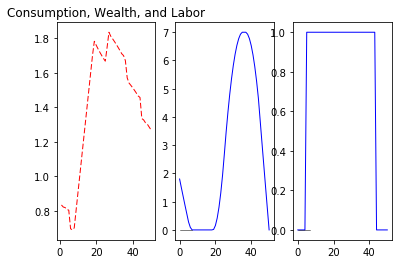

In [63]:
# Initialize
T = 50
na = 801
amax = 7
nh = 2

V = np.zeros((na,T))
sav = np.zeros((na,T))
savind = np.zeros((na,T))
con = np.zeros((na,T))
h = np.zeros((na,T))

a_grid = np.linspace(amin,amax,na)
#print(agrid)
h_grid = np.linspace(0,1,nh)


hvals = np.linspace(0,1,nh)
## Decisions at t=T
#savind[:,T-1] = [i for i in range(0,len(agrid)) if agrid[i]==0]
sav[:,T-1] =0
hind = np.zeros((na,T))
conh = np.zeros((na,nh))
Vh = np.zeros((na,nh))
#print(conh.shape)
#psi = -0.5
for i in range(nh):
    #hind[:,T-1] = np.zeros((na,1))
    #print(a_grid.shape)
    conh[:,i] = R*a_grid + w(T)*hvals[i] + (1-hvals[i])*b - sav[:,T-1]
    Vh[:,i] = u(conh[:,i],hvals[i])

Vh
#print(conh)
#print(Vh)
V[:,T-1] = np.amax(Vh,1)
#print(V)
hind = np.argmax(Vh,1)
#print(hind)
con[:,T-1] = np.choose(hind, conh.T)
#print(con)
h[:,T-1] = np.choose(hind, h_grid.T)
#print(h)



cash = np.zeros(conh.shape)
#print(cash)
# Solving backward
for it in np.arange(T-2,-1,-1):
    print("Solving at age ", (it+1))
    for ia in range(0,na):
        for i in range(nh):
            #hind[:,T-1] = np.zeros((na,1))
            #print(a_grid.shape)
            #conh[:,i] 
            #print(cash[:])
            cash[:,i] = R*a_grid[ia] + w(it+1,tau)*hvals[i] + (1-hvals[i])*b
            #print(cash[:,i])
            conh[:,i] = np.maximum((cash[:,i] - a_grid), 1 * 10 ** -10)
            #print(c)
            Vh[:,i] = u(conh[:,i],hvals[i]) + beta * V[:,it+1] 
        #print(Vh)
        hind = np.argmax(Vh,1)
        #print(hind)
        cashchoice = np.choose(hind, cash.T)
        conchoice = np.choose(hind, conh.T)
        hchoice = np.choose(hind, h_grid.T)
        #print("dw",hchoice[4])
        #print("hchoice",hchoice)
        Vchoice = np.amax(Vh,1)
        #print("Vchoice",Vchoice)
        Vind = np.argmax(Vchoice)
        #print(Vind)
        V[ia,it] = np.max(Vchoice)
        #print("h",h)
        h[ia,it] = hchoice[Vind]
        #print(h)
        sav[ia,it]= a_grid[Vind]
        savind[ia,it] = Vind
        con[ia,it] = cashchoice[Vind] -sav[ia,it]
        
        
        
aindsim = np.zeros(T+1)
hsim = np.zeros(T+1)
csim = np.zeros(T+1)
asim = np.zeros(T+1)

# initial assets
ainitial = 1.8

# allocate to nearest point on agrid
inter = interpolate.interp1d(a_grid,range(0,na),'nearest')
#print(inter)
aindsim[0] = inter(ainitial) #a_grid[np.int(inter(ainitial))]   
asim[0] = a_grid[np.int(aindsim[0])]

asim
for it in range(0,T):
    print('Simulating, time period', (it+1))
    #asset choice
    aindsim[it+1] = savind[np.int_(aindsim[it]),it]
    asim[it+1] = a_grid[np.int(aindsim[it+1])]
    hsim[it] = h[np.int(aindsim[it]),it]
    csim[it] = R*asim[it] + w(it,tau)*hsim[it] + (1 - hsim[it])*b - asim[it+1]
print(hsim)
asim
csim



fig_1 = plt.figure(1)
plt.title('Consumption, Wealth, and Labor')
#fig_1.figsize((10,10))
#consumption and income path
plt.subplot(1,3,1)
#plt.plot(range(1,51),y, 'k-', lw=1)
plt.plot(range(1,T+1),csim[0:T],'r--', lw=1)
plt.grid
plt.title('Consumption, Wealth, and Labor')
plt.legend(label = ('Income','Consumption'))
#plt.show()

plt.subplot(1,3,2)
plt.plot(range(0,T+1),asim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)


plt.subplot(1,3,3)
plt.plot(range(0,T+1),hsim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)
plt.show()

 - We can see that she accumulates less wealth in her middle-aged period, trading it for consumption.

## ii. The household faces a proportional tax τ = 40% on their wage income.
Unemployment benefits are not taxed.

In [64]:
r = 0.03
R = 1 + r
tau = 0.4

Solving at age  49
Solving at age  48
Solving at age  47
Solving at age  46
Solving at age  45
Solving at age  44
Solving at age  43
Solving at age  42
Solving at age  41
Solving at age  40
Solving at age  39
Solving at age  38
Solving at age  37
Solving at age  36
Solving at age  35
Solving at age  34
Solving at age  33
Solving at age  32
Solving at age  31
Solving at age  30
Solving at age  29
Solving at age  28
Solving at age  27
Solving at age  26
Solving at age  25
Solving at age  24
Solving at age  23
Solving at age  22
Solving at age  21
Solving at age  20
Solving at age  19
Solving at age  18
Solving at age  17
Solving at age  16
Solving at age  15
Solving at age  14
Solving at age  13
Solving at age  12
Solving at age  11
Solving at age  10
Solving at age  9
Solving at age  8
Solving at age  7
Solving at age  6
Solving at age  5
Solving at age  4
Solving at age  3
Solving at age  2
Solving at age  1
Simulating, time period 1
Simulating, time period 2
Simulating, time period 3


/Users/Jan/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


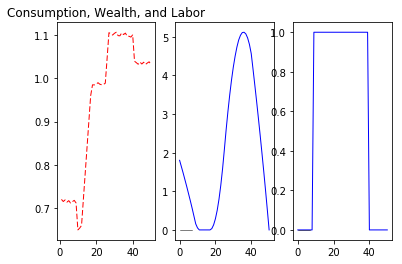

In [65]:
# Initialize
T = 50
na = 801
amax = 7
nh = 2

V = np.zeros((na,T))
sav = np.zeros((na,T))
savind = np.zeros((na,T))
con = np.zeros((na,T))
h = np.zeros((na,T))

a_grid = np.linspace(amin,amax,na)
#print(agrid)
h_grid = np.linspace(0,1,nh)


hvals = np.linspace(0,1,nh)
## Decisions at t=T
#savind[:,T-1] = [i for i in range(0,len(agrid)) if agrid[i]==0]
sav[:,T-1] =0
hind = np.zeros((na,T))
conh = np.zeros((na,nh))
Vh = np.zeros((na,nh))
#print(conh.shape)
#psi = -0.5
for i in range(nh):
    #hind[:,T-1] = np.zeros((na,1))
    #print(a_grid.shape)
    conh[:,i] = R*a_grid + w(T)*hvals[i] + (1-hvals[i])*b - sav[:,T-1]
    Vh[:,i] = u(conh[:,i],hvals[i])

Vh
#print(conh)
#print(Vh)
V[:,T-1] = np.amax(Vh,1)
#print(V)
hind = np.argmax(Vh,1)
#print(hind)
con[:,T-1] = np.choose(hind, conh.T)
#print(con)
h[:,T-1] = np.choose(hind, h_grid.T)
#print(h)



cash = np.zeros(conh.shape)
#print(cash)
# Solving backward
for it in np.arange(T-2,-1,-1):
    print("Solving at age ", (it+1))
    for ia in range(0,na):
        for i in range(nh):
            #hind[:,T-1] = np.zeros((na,1))
            #print(a_grid.shape)
            #conh[:,i] 
            #print(cash[:])
            cash[:,i] = R*a_grid[ia] + w(it+1,tau)*hvals[i] + (1-hvals[i])*b
            #print(cash[:,i])
            conh[:,i] = np.maximum((cash[:,i] - a_grid), 1 * 10 ** -10)
            #print(c)
            Vh[:,i] = u(conh[:,i],hvals[i]) + beta * V[:,it+1] 
        #print(Vh)
        hind = np.argmax(Vh,1)
        #print(hind)
        cashchoice = np.choose(hind, cash.T)
        conchoice = np.choose(hind, conh.T)
        hchoice = np.choose(hind, h_grid.T)
        #print("dw",hchoice[4])
        #print("hchoice",hchoice)
        Vchoice = np.amax(Vh,1)
        #print("Vchoice",Vchoice)
        Vind = np.argmax(Vchoice)
        #print(Vind)
        V[ia,it] = np.max(Vchoice)
        #print("h",h)
        h[ia,it] = hchoice[Vind]
        #print(h)
        sav[ia,it]= a_grid[Vind]
        savind[ia,it] = Vind
        con[ia,it] = cashchoice[Vind] -sav[ia,it]
        
        
        
aindsim = np.zeros(T+1)
hsim = np.zeros(T+1)
csim = np.zeros(T+1)
asim = np.zeros(T+1)

# initial assets
ainitial = 1.8

# allocate to nearest point on agrid
inter = interpolate.interp1d(a_grid,range(0,na),'nearest')
#print(inter)
aindsim[0] = inter(ainitial) #a_grid[np.int(inter(ainitial))]   
asim[0] = a_grid[np.int(aindsim[0])]

asim
for it in range(0,T):
    print('Simulating, time period', (it+1))
    #asset choice
    aindsim[it+1] = savind[np.int_(aindsim[it]),it]
    asim[it+1] = a_grid[np.int(aindsim[it+1])]
    hsim[it] = h[np.int(aindsim[it]),it]
    csim[it] = R*asim[it] + w(it,tau)*hsim[it] + (1 - hsim[it])*b - asim[it+1]
print(hsim)
asim
csim



fig_1 = plt.figure(1)
plt.title('Consumption, Wealth, and Labor')
#fig_1.figsize((10,10))
#consumption and income path
plt.subplot(1,3,1)
#plt.plot(range(1,51),y, 'k-', lw=1)
plt.plot(range(1,T+1),csim[0:T],'r--', lw=1)
plt.grid
plt.title('Consumption, Wealth, and Labor')
plt.legend(label = ('Income','Consumption'))
#plt.show()

plt.subplot(1,3,2)
plt.plot(range(0,T+1),asim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)


plt.subplot(1,3,3)
plt.plot(range(0,T+1),hsim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)
plt.show()

 - We can see that she starts working later, stops working earlier, and accumulates less wealth overall.

## iii. Unemployment benefits are reduced to b = 0.1

In [66]:

tau = 0
b = 0.1

Solving at age  49
Solving at age  48
Solving at age  47
Solving at age  46
Solving at age  45
Solving at age  44
Solving at age  43
Solving at age  42
Solving at age  41
Solving at age  40
Solving at age  39
Solving at age  38
Solving at age  37
Solving at age  36
Solving at age  35
Solving at age  34
Solving at age  33
Solving at age  32
Solving at age  31
Solving at age  30
Solving at age  29
Solving at age  28
Solving at age  27
Solving at age  26
Solving at age  25
Solving at age  24
Solving at age  23
Solving at age  22
Solving at age  21
Solving at age  20
Solving at age  19
Solving at age  18
Solving at age  17
Solving at age  16
Solving at age  15
Solving at age  14
Solving at age  13
Solving at age  12
Solving at age  11
Solving at age  10
Solving at age  9
Solving at age  8
Solving at age  7
Solving at age  6
Solving at age  5
Solving at age  4
Solving at age  3
Solving at age  2
Solving at age  1
Simulating, time period 1
Simulating, time period 2
Simulating, time period 3


/Users/Jan/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


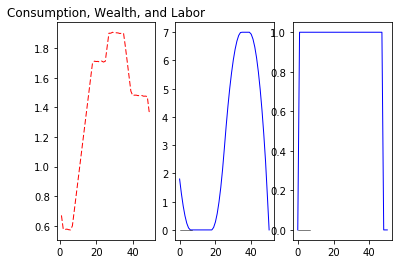

In [67]:
T = 50
na = 801
amax = 7
nh = 2

V = np.zeros((na,T))
sav = np.zeros((na,T))
savind = np.zeros((na,T))
con = np.zeros((na,T))
h = np.zeros((na,T))

a_grid = np.linspace(amin,amax,na)
#print(agrid)
h_grid = np.linspace(0,1,nh)


hvals = np.linspace(0,1,nh)
## Decisions at t=T
#savind[:,T-1] = [i for i in range(0,len(agrid)) if agrid[i]==0]
sav[:,T-1] =0
hind = np.zeros((na,T))
conh = np.zeros((na,nh))
Vh = np.zeros((na,nh))
#print(conh.shape)
#psi = -0.5
for i in range(nh):
    #hind[:,T-1] = np.zeros((na,1))
    #print(a_grid.shape)
    conh[:,i] = R*a_grid + w(T)*hvals[i] + (1-hvals[i])*b - sav[:,T-1]
    Vh[:,i] = u(conh[:,i],hvals[i])

Vh
#print(conh)
#print(Vh)
V[:,T-1] = np.amax(Vh,1)
#print(V)
hind = np.argmax(Vh,1)
#print(hind)
con[:,T-1] = np.choose(hind, conh.T)
#print(con)
h[:,T-1] = np.choose(hind, h_grid.T)
#print(h)



cash = np.zeros(conh.shape)
#print(cash)
# Solving backward
for it in np.arange(T-2,-1,-1):
    print("Solving at age ", (it+1))
    for ia in range(0,na):
        for i in range(nh):
            #hind[:,T-1] = np.zeros((na,1))
            #print(a_grid.shape)
            #conh[:,i] 
            #print(cash[:])
            cash[:,i] = R*a_grid[ia] + w(it+1,tau)*hvals[i] + (1-hvals[i])*b
            #print(cash[:,i])
            conh[:,i] = np.maximum((cash[:,i] - a_grid), 1 * 10 ** -10)
            #print(c)
            Vh[:,i] = u(conh[:,i],hvals[i]) + beta * V[:,it+1] 
        #print(Vh)
        hind = np.argmax(Vh,1)
        #print(hind)
        cashchoice = np.choose(hind, cash.T)
        conchoice = np.choose(hind, conh.T)
        hchoice = np.choose(hind, h_grid.T)
        #print("dw",hchoice[4])
        #print("hchoice",hchoice)
        Vchoice = np.amax(Vh,1)
        #print("Vchoice",Vchoice)
        Vind = np.argmax(Vchoice)
        #print(Vind)
        V[ia,it] = np.max(Vchoice)
        #print("h",h)
        h[ia,it] = hchoice[Vind]
        #print(h)
        sav[ia,it]= a_grid[Vind]
        savind[ia,it] = Vind
        con[ia,it] = cashchoice[Vind] -sav[ia,it]
        
        
        
aindsim = np.zeros(T+1)
hsim = np.zeros(T+1)
csim = np.zeros(T+1)
asim = np.zeros(T+1)

# initial assets
ainitial = 1.8

# allocate to nearest point on agrid
inter = interpolate.interp1d(a_grid,range(0,na),'nearest')
#print(inter)
aindsim[0] = inter(ainitial) #a_grid[np.int(inter(ainitial))]   
asim[0] = a_grid[np.int(aindsim[0])]

asim
for it in range(0,T):
    print('Simulating, time period', (it+1))
    #asset choice
    aindsim[it+1] = savind[np.int_(aindsim[it]),it]
    asim[it+1] = a_grid[np.int(aindsim[it+1])]
    hsim[it] = h[np.int(aindsim[it]),it]
    csim[it] = R*asim[it] + w(it,tau)*hsim[it] + (1 - hsim[it])*b - asim[it+1]
print(hsim)
asim
csim



fig_1 = plt.figure(1)
plt.title('Consumption, Wealth, and Labor')
#fig_1.figsize((10,10))
#consumption and income path
plt.subplot(1,3,1)
#plt.plot(range(1,51),y, 'k-', lw=1)
plt.plot(range(1,T+1),csim[0:T],'r--', lw=1)
plt.grid
plt.title('Consumption, Wealth, and Labor')
plt.legend(label = ('Income','Consumption'))
#plt.show()

plt.subplot(1,3,2)
plt.plot(range(0,T+1),asim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)


plt.subplot(1,3,3)
plt.plot(range(0,T+1),hsim, 'b-',lw=1)
plt.plot(a_grid,np.zeros(na),'k',lw=.5)
plt.show()

- We can immediately see that she starts working earlier, and retires later.